# ☁️ Hybrid Quantum Computing Cloud Service - QuREKA  

**QuREKA** is a cloud computing platform currently being developed at **SDT**.  
It is based on **Kreo** by **Anyon**, but is also designed to be compatible with external **QPUs** and quantum emulators.  

This platform is dedicated to **hybrid quantum computing**, with support for:  
- **CUDA-Q**  
- **PennyLane**  

<br>

![QuREKA](images/QuREKA.png)

# Using Hybrid Quantum Computing to solve Financial Problems

In the NISQ (Noisy Intermediate-Scale Quantum) era, hybrid quantum computing is one of the most effective ways to harness computational power from quantum systems. The Quantum Approximate Optimization Algorithm (QAOA) is a key example, designed to solve combinatorial optimization problems, many of which are NP-hard or NP-complete. One notable case is the Quadratic Unconstrained Binary Optimization (QUBO) problem, where QAOA can be applied. QUBO models appear in various real-world applications, including portfolio optimization and decision-making in finance.

## Quadratic Unconstrained Binary Optimization (QUBO) problems

A **Quadratic Unconstrained Binary Optimization (QUBO)** problem is a mathematical formulation where the goal is to minimize a quadratic function over binary variables. Specifically, given a symmetric matrix $Q \in \mathbb{R}^{n \times n}$ and a binary vector $x \in \{0, 1\}^n$, the QUBO problem is defined as:

$$
\min_x  \quad x^T Q x
$$

where:  
- $x_i \in \{0, 1\}$ in $x = (x_1, x_2, \dots, x_n)$ are binary decision variables.  
- $Q$ is the **QUBO matrix**, containing the problem coefficients.  
- $x^T Q x$ represents a quadratic cost function over these binary variables.  

The QUBO framework is highly general and can express a wide range of combinatorial optimization problems. Examples include:  
- Graph problems (e.g., Max-Cut).  
- Scheduling and assignment problems.  
- Financial optimization tasks like portfolio selection and asset-liability management.
  
  In particular, [this study](https://www.actuaries.org.uk/system/files/field/document/assetliability-modelling-in-the-quantum-era.%20to%20use.pdf) shows how an asset-liability management problem can be formulated as a QUBO by constructing a $Q$ matrix that encodes the relationships between assets, liabilities, and risk constraints.  
  The $Q$ matrix introduced in that work will also be used in this notebook as the problem instance to be solved using QAOA.


QUBO is widely studied because of its simplicity and flexibility: the entire problem is encoded in a single matrix $Q$, making it well-suited for optimization techniques, including quantum algorithms.


## Quantum Approximate Optimization Algorithm (QAOA)

The **Quantum Approximate Optimization Algorithm (QAOA)** is a variational quantum algorithm to solve combinatorial optimization problems by evolving an initial quantum state to the approximate the ground state of a problem's (cost) Hamiltonian.

QAOA is inspired by the **Trotterization** of unitary time evolution in quantum mechanics, where the evolution under a Hamiltonian $H = A + B$ (with generally non-commuting terms $A$ and $B$) is approximated as:

$$
U = e^{-i(A+B)t} \approx \left( e^{-iAt/N} e^{-iBt/N} \right)^N
$$

for sufficiently large $N$ by Trotter product formula. This motivates QAOA's structure, which alternates two types of operations — one based on the problem's cost Hamiltonian $H_C$ and one based on a mixing Hamiltonian $H_M$, which exists for the quantum state to converge to the ground state. The exact unitary transformation before the Trotterization aims have the ground state as the final product by **having different time dependences** for each of $A,B$. This means in the Trotterized sense, they have different sets of coefficients *$\{\gamma\}. \{\beta\}$* as below: <br>
<br>
![qaoa_circuit](images/qaoa_circ.png)<br>
<br>
This set of alternating operations is repeated for a chosen depth $p$. Each layer applies:

1. The **cost unitary**: $U_C(\gamma) = e^{-i\gamma H_C}$
2. The **mixer unitary**: $U_M(\beta) = e^{-i\beta H_M}$

From the Trotter product formula, the larger the p the more accurate the algorihtm. However, even for small values of p, the parameters $\gamma$ and $\beta$ can get optimized on classical computers by minimizing the expectation value of the cost Hamiltonian. Then one could get a **quantum state that is an approximate solution to the cost minimization**, but also hopefully have large weight of the ground state among all other eigenstates of the cost Ising Hamiltonian it is superposed in.

<br>

### From QUBO to QAOA via the Ising Model  

A key reason why QAOA applies naturally to QUBO problems is that **binary variables** and the **quadratic form** of the QUBO cost function map directly onto the **Ising model** from quantum mechanics.  

#### 🔹 QUBO Form:  
$$
\sum_i Q_{ii} x_i + \sum_{i,j} Q_{ij} x_i x_j, \quad x_i \in \{0, 1\}
$$

#### 🔹 Ising Hamiltonian:  
$$
H = \sum_i h_i Z_i + \sum_{i,j} J_{ij} Z_i Z_j, \quad z_i \in \{1, -1\}
$$

via the variable transformation:  
$$
x_i = \frac{1 - Z_i}{2}
$$

This substitution leads to the explicit form of the Hamiltonian:  
$$
Q_{ii} \left( \frac{1 - Z_i}{2} \right) + \frac{Q_{ij}}{4} (1 - Z_i - Z_j + Z_i Z_j)
$$

which gives the Ising coefficients:  
- $h_i = -\frac{Q_{ii}}{2} - \sum_j \frac{Q_{ij}}{4}$  
- $J_{ij} = \frac{Q_{ij}}{4}$  


# Imports 
from `__init__.py`


In [17]:
from src_cudaq.qaoa_converter import (
    Q_to_Ising,
    create_cost_Hamiltonian,
    create_mixer_Hamiltonian
)

from src_cudaq.fourier import (
    build_fourier_params,
    fourier_amplitude_init
)

from src_cudaq.circuits import (
    qaoa_fourier_kernel,
    cost_function_fourier,
    calculate_cost
)

from src_cudaq.optimizer import (
    run_qaoa_cudaq_opt,
    run_qaoa_opt,
    run_qaoa_glob_opt
)

import numpy as np
import matplotlib.pyplot as plt
import cudaq
from cudaq import spin
from collections import defaultdict

# QUBO Matrix Q
Again, the QUBO matrix is given in this [study](https://www.actuaries.org.uk/system/files/field/document/assetliability-modelling-in-the-quantum-era.%20to%20use.pdf) to model the asset-liability management.

![QUBO Matrix](images/Q_matrix.png)

In [18]:
Q = np.array([
    [-180329,  28009,   63588,   69151,   34198,   -984,   -1967,   -3935,   -7870,  -15739,  -31478],
    [      0, -110296,  36811,   40032,   19798,   -569,   -1139,   -2278,   -4556,   -9111,  -18223],
    [      0,       0, -226999,  90883,   44946,   -1293,  -2586,   -5171,  -10343,  -20685,  -41371],
    [      0,       0,       0, -242882,   48878,  -1406,  -2812,   -5624,  -11248,  -22495,  -44990],
    [      0,       0,       0,       0, -132474,   -695,  -1391,   -2781,   -5562,  -11125,  -22250],
    [      0,       0,       0,       0,       0,   4169,     40,      80,     160,     320,     640],
    [      0,       0,       0,       0,       0,       0,   8358,    160,     320,     640,    1280],
    [      0,       0,       0,       0,       0,       0,      0,  16796,     640,    1280,    2560],
    [      0,       0,       0,       0,       0,       0,      0,      0,   33912,    2560,    5120],
    [      0,       0,       0,       0,       0,       0,      0,      0,       0,   69104,   10240],
    [      0,       0,       0,       0,       0,       0,      0,      0,       0,       0,  143329]
])

depth=10
q=3 # Doesn't get much better
num_qubits = Q.shape[0]
max_iterations = 150

_,_,_,coeff_max = Q_to_Ising(Q)
optimum_known = calculate_cost("11110101000",Q)
print(f"The minimum cost should be: {optimum_known} or in the normazlied value: {optimum_known/coeff_max} ")
optimum_known/=coeff_max


The minimum cost should be: -432247 or in the normazlied value: -5.313505124540942 


In [19]:
# Cost and Mixer Hamiltonians

cost_operator, cost_pauli_coeffs, cost_pauli_words, offset = create_cost_Hamiltonian(Q)
mixer_operator, mixer_words = create_mixer_Hamiltonian(num_qubits)

print("The cost Hamiltonian:\n")
print(cost_operator)
print("The mixer Hamiltonian:\n")
print(mixer_operator)

The cost Hamiltonian:

[-0.09673781096820787+0j] ZIIIIIIIIIZ
[0.11312712242044284+0j] IZZIIIIIIII
[0.06084297546059405+0j] IZIIZIIIIII
[-0.007000722199173312+0j] IZIIIIIZIII
[-0.003973632047204167+0j] IIZIIZIIIII
[-0.034567218303907556+0j] IIIZIIIIZII
[-0.007947264094408334+0j] IIZIIIZIIII
[0.0009834201508935295+0j] IIIIIZIIIZI
[-0.017093071497718156+0j] IIIIZIIIZII
[-0.13826272683968716+0j] IIIZIIIIIIZ
[-0.006044960740023663+0j] ZIIIIIZIIII
[0.00024585503772338237+0j] IIIIIZIZIII
[-0.11384624840578374+0j] IIIIIIIIZII
[0.21251402142012016+0j] ZIIZIIIIIII
[0.0860769218949277+0j] ZZIIIIIIIII
[-0.003024016963997603+0j] ZIIIIZIIIII
[0+0j] IIIIIIIIIII
[-0.06913136341984358+0j] IIIZIIIIIZI
[-0.003500361099586656+0j] IZIIIIZIIII
[-0.014231933496212296+0j] IIIIIZIIIII
[0.4051014920327602+0j] IZIIIIIIIII
[-0.01589145500084513+0j] IIZIIIIZIII
[0.4945742866362421+0j] IIIIZIIIIII
[0.001966840301787059+0j] IIIIIIIZZII
[-0.03418921618340786+0j] IIIIZIIIIZI
[0.00012292751886169119+0j] IIIIIZZIIII
[0.

# QAOA Implementation 
- circuit depth = 10
- qubits used = 11
- #. of iterations in the optimizer = 150,
-  #. of parameters to optimize (FOURIER_amplitude) = 3

## Optimization from a random point in the parameter space

With the Hamiltonians set up, the parameters get optimized by a **classical** optimizer, starting from an initial random point. The way it gets initialized is **not completely random** in this project. in that the paraemters are being imposed by some ansatz patterns (FOURIER heuristics), which will be addressed shortly. 

In [20]:
# 'scipy.optimize' package used to show the optimization process (gradient optimizer 'L-BFGS-B' used);

run_qaoa_opt(
        depth=depth,
        q=q,
        num_qubits=num_qubits,
        cost_operator=cost_operator,
        cost_pauli_coeffs=cost_pauli_coeffs,
        cost_pauli_words=cost_pauli_words,
        mixer_words=mixer_words,
        offset=offset,
        optimum_known = optimum_known,
        max_iterations=max_iterations,
        seed = 278 ,
        verbose=True
    )

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.89610D+00    |proj g|=  4.09719D+00

At iterate    1    f= -3.55240D+00    |proj g|=  5.95249D+00

At iterate    2    f= -4.80240D+00    |proj g|=  6.28319D+00

At iterate    3    f= -5.01178D+00    |proj g|=  5.75080D+00
  ys=-8.556E+00  -gs= 4.351E-01 BFGS update SKIPPED

At iterate    4    f= -5.01179D+00    |proj g|=  1.96478D+00

At iterate    5    f= -5.01180D+00    |proj g|=  6.26270D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


(-5.0117967331021,
 array([-0.59144982, -1.23557878, -0.5944655 ,  1.2818081 ,  3.55531582,
         5.08134503,  5.08097885,  3.60971771,  1.54401631,  0.08870448,
        -2.31010912, -0.14403824,  3.07968325,  5.75022632,  6.6210233 ,
         5.44658762,  3.03739724,  0.72084443, -0.4610418 , -0.34069226]))


At iterate    6    f= -5.01180D+00    |proj g|=  5.75098D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6     59     11     1     0   5.751D+00  -5.012D+00
  F =  -5.0117967331021003     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [21]:
import time

In [22]:
# Computation time comparison - cudaq native optimizer
start_time = time.time()

final_cost, optimal_amps = run_qaoa_cudaq_opt(
    depth=depth,
    q=q,
    num_qubits=num_qubits,
    cost_operator=cost_operator,
    cost_pauli_coeffs=cost_pauli_coeffs,
    cost_pauli_words=cost_pauli_words,
    mixer_words=mixer_words,
    offset=offset,
    optimum_known=optimum_known,
    max_iterations=max_iterations,
    seed=278,
    verbose=True
)
time_taken = time.time() - start_time
print(f"final_cost: {final_cost}, approximation ratio: {final_cost/optimum_known}")
print(f"time_taken:{time_taken} seconds ")

final_cost: -4.885194091029705, approximation ratio: 0.9193919976602561
time_taken:2.6153621673583984 seconds 


In [23]:
# Computation time comparison - 'scipy.optimize' package
start_time = time.time()

final_cost, optimal_amps= run_qaoa_opt(
        depth=depth,
        q=q,
        num_qubits=num_qubits,
        cost_operator=cost_operator,
        cost_pauli_coeffs=cost_pauli_coeffs,
        cost_pauli_words=cost_pauli_words,
        mixer_words=mixer_words,
        offset=offset,
        optimum_known = optimum_known,
        max_iterations=max_iterations,
        seed = 278 ,
        verbose=False
    )
time_taken = time.time() - start_time
print(f"final_cost: {final_cost}, approximation ratio: {final_cost/optimum_known}")
print(f"time_taken:{time_taken} seconds")

final_cost: -5.0117967331021, approximation ratio: 0.9432185752404054
time_taken:5.707767009735107 seconds


###  Comments:
- CudaQ native is **Much faster** thanks to GPU acceleration.
- It is best suited for **smooth optimization landscapes**.
- Often struggles with highly rugged, local-minima-dense problems like QUBO, potentially leading to a **worse approximation ratio**. (Note that the same seed number is used for both optimizer types)
- Directly optimize the QAOA parameters using `cudaq.vqe()`.

## Restarts with FOURIER heuristics
Since the parameter landscape for QUBO problems is often highly non-convex with many plateaus and local optima, iterative random restarts over the parameter space are essential for local optimizers. This typically requires $2^{O(p)}$ optimization runs (note that this is exponential in $p$, which can be set smaller than the number of qubits required, contrasting with the classical computational complexity).

One way to reduce the computational complexity is to selectively restrict the search. FOURIER heuristics is such an approach, applying a Discrete Sine/Cosine Transform under the assumption of smooth variations in the parameters. This can reduce the number of parameters and thecomplexity to $O(\text{poly}(p))$. See this [paper](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.10.021067) for more.

In [14]:
# --- QAOA Restarts ---
num_restarts = 50
best_cost = np.inf
best_params = None
all_costs = []
all_params = []

for restart in range(num_restarts):
    print(f"\n🔹 Restart {restart + 1}/{num_restarts}")
    
    # Run the optimization
    value, parameters = run_qaoa_opt(
        depth=depth,
        q=q,
        num_qubits=num_qubits,
        cost_operator=cost_operator,
        cost_pauli_coeffs=cost_pauli_coeffs,
        cost_pauli_words=cost_pauli_words,
        mixer_words=mixer_words,
        offset=offset,
        optimum_known = optimum_known,
        max_iterations=max_iterations,
        seed = restart ,
        verbose=False
    )
    
    print(f"🔻 Local minimum cost: {value}, approximation ratio: {100*value/optimum_known}%")

    all_costs.append(value)
    all_params.append(parameters)

    if value < best_cost:
        best_cost = value
        best_params = parameters

# --- Results ---
print(f"\n✅ Best cost found over {num_restarts} restarts: {best_cost}. approximation ratio: {100*best_cost/optimum_known}%")
init_amps = build_fourier_params(
    fourier_amplitude_init(q), depth, q
)


print(init_amps)


🔹 Restart 1/50
🔻 Local minimum cost: -4.991924655897266, approximation ratio: 93.94786565353208%

🔹 Restart 2/50
🔻 Local minimum cost: -4.894750052850225, approximation ratio: 92.11904266815033%

🔹 Restart 3/50
🔻 Local minimum cost: -4.312660139301361, approximation ratio: 81.16412872894239%

🔹 Restart 4/50
🔻 Local minimum cost: -3.686222528072743, approximation ratio: 69.37459250857903%

🔹 Restart 5/50
🔻 Local minimum cost: -5.007825181170944, approximation ratio: 94.24711304110379%

🔹 Restart 6/50
🔻 Local minimum cost: -4.110984159946673, approximation ratio: 77.36859311492316%

🔹 Restart 7/50
🔻 Local minimum cost: -4.868104466472575, approximation ratio: 91.61757356718749%

🔹 Restart 8/50
🔻 Local minimum cost: -3.247294687341768, approximation ratio: 61.11398429529729%

🔹 Restart 9/50
🔻 Local minimum cost: -4.953602987538993, approximation ratio: 93.22665305544346%

🔹 Restart 10/50
🔻 Local minimum cost: -5.002884305061643, approximation ratio: 94.15412590749811%

🔹 Restart 11/50
🔻 

## Overall Complexity of QAOA

For QAOA applied to QUBO problems:

- **Single evaluation cost:**  
  Each call to `cudaq.observe()` (i.e., one cost function evaluation) scales as  
  $O(\text{poly}(n))$  
  where $n$ is the number of qubits (problem size). This accounts for the quantum circuit execution, though **memory** and **runtime** can grow quickly depending on the backend.

- **Total cost per optimization run:**  
  This depends on the optimizer and the number of function evaluations $N_{\text{evals}}$:  
  $O(N_{\text{evals}} \cdot \text{poly}(n))$  
  Local optimizers like **L-BFGS-B** may require fewer evaluations, while global optimizers like **Differential Evolution** typically need significantly more.

- **Total QAOA complexity with FOURIER heuristics:**  
  Since FOURIER heuristics can reduce the number of parameters from $p$ QAOA layers to $q < p$ Fourier modes, and the required restarts scale like $O(\text{poly}(q))$,  
  the total computational complexity becomes:  
  $$
  O\big( \text{poly}(q) \cdot N_{\text{evals}} \cdot \text{poly}(n) \big)
  $$

> **Note:**  
> The dominant computational cost in practice is often the **number of function evaluations** due to repeated quantum circuit simulations, especially as the number of qubits $n$ grows.

- **Vs Classical:**  
 This scaling suggests that QAOA with FOURIER heuristics could outperform classical algorithms on large combinatorial spaces, where the classical cost grows exponentially with problem size.


## Approximation ratio over the circuit depth


🔥 Running for depth p = 3
✅ Best approximation ratio at depth 3: 0.9469155992473015

🔥 Running for depth p = 6
✅ Best approximation ratio at depth 6: 0.9473004626336634

🔥 Running for depth p = 9
✅ Best approximation ratio at depth 9: 0.9473277917115119

🔥 Running for depth p = 12
✅ Best approximation ratio at depth 12: 0.9472790523271561

🔥 Running for depth p = 15
✅ Best approximation ratio at depth 15: 0.9471878669863495

🔥 Running for depth p = 18
✅ Best approximation ratio at depth 18: 0.9435333870860185


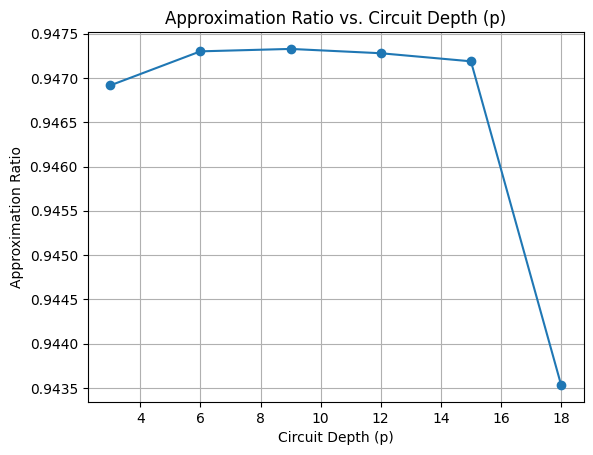

In [16]:
depths = list(range(3, 21, 3))
approx_ratios = []

for depth in depths:
    print(f"\n🔥 Running for depth p = {depth}")
    
    best_cost = np.inf
    num_restarts = 27  # or whatever you want

    for restart in range(num_restarts):
        value, _ = run_qaoa_opt(
            depth=depth,
            q=q,
            num_qubits=num_qubits,
            cost_operator=cost_operator,
            cost_pauli_coeffs=cost_pauli_coeffs,
            cost_pauli_words=cost_pauli_words,
            mixer_words=mixer_words,
            offset=offset,
            optimum_known=optimum_known,
            max_iterations=max_iterations,
            seed=restart,
            verbose=False
        )
        if value < best_cost:
            best_cost = value

    approx_ratio = best_cost / optimum_known
    approx_ratios.append(approx_ratio)
    print(f"✅ Best approximation ratio at depth {depth}: {approx_ratio}")

# Plot the results
plt.plot(depths, approx_ratios, marker='o')
plt.xlabel('Circuit Depth (p)')
plt.ylabel('Approximation Ratio')
plt.title('Approximation Ratio vs. Circuit Depth (p)')
plt.grid(True)
plt.show()

- Not enough restarts;
- FOURIER Heuristics seem to be slightly inappropriate for this particular problem. (see the 'QAOA_Pennylane.ipynb') 

# References

- Zhou et al. (2019). *Quantum Approximate Optimization Algorithm: Performance, Mechanism, and Implementation on Near-Term Devices*. [arXiv:1812.01041](https://arxiv.org/pdf/1812.01041)

- Institute and Faculty of Actuaries. *Asset Liability Modelling in the Quantum Era*. [Link](https://www.actuaries.org.uk/system/files/field/document/assetliability-modelling-in-the-quantum-era.%20to%20use.pdf)

- PennyLane. *Introduction to QAOA*. [Tutorial](https://pennylane.ai/qml/demos/tutorial_qaoa_intro)

- PennyLane. *Solving QUBO Problems with QAOA*. [Tutorial](https://pennylane.ai/qml/demos/tutorial_QUBO)
